In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import numpy as np

In [2]:
!pip install pmdarima


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# BITCOIN

In [3]:
data = pd.read_csv('Bitcoin Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2013-03-01,34.5,33.4,34.9,32.9,39.79K,3.36%
2013-03-02,34.3,34.5,34.8,33.2,36.66K,-0.72%
2013-03-03,34.5,34.3,34.5,33.8,12.53K,0.73%
2013-03-04,36.2,34.5,36.7,34.2,46.77K,4.78%
2013-03-05,40.3,36.2,40.7,36.2,85.43K,11.56%
...,...,...,...,...,...,...
2024-05-28,68366.0,69428.3,69560.7,67299.9,71.39K,-1.53%
2024-05-29,67635.8,68366.2,68897.6,67143.2,52.13K,-1.07%
2024-05-30,68354.7,67631.3,69504.7,67138.4,66.84K,1.06%


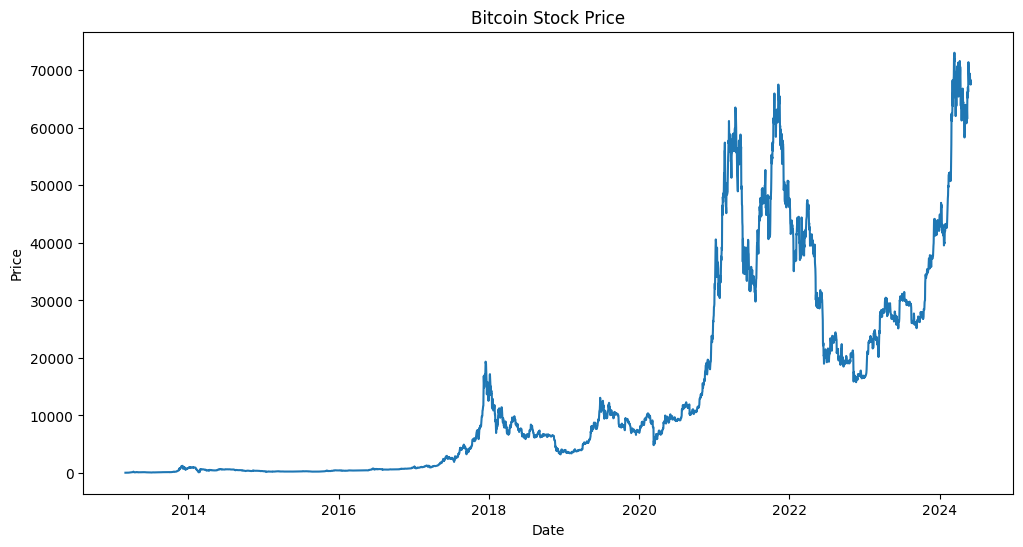

In [4]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['Price'])
plt.title('Bitcoin Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=4.30 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=52541.533, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=52532.579, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=52531.987, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=52540.704, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=52540.418, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=52533.576, Time=0.58 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=52532.540, Time=0.39 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=52532.530, Time=0.30 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=52530.947, Time=1.06 sec
 ARIMA(0,1,1)(2,0,2)[4] intercept   : AIC=52460.506, Time=2.48 sec
 ARIMA(0,1,1)(2,0,1)[4] intercept   : AIC=52528.544, Time=0.84 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AIC=52459.643, Time=1.80 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=52532.280, Time=0.81 sec
 ARIMA(0,1,0)(2,0,1)[4] i

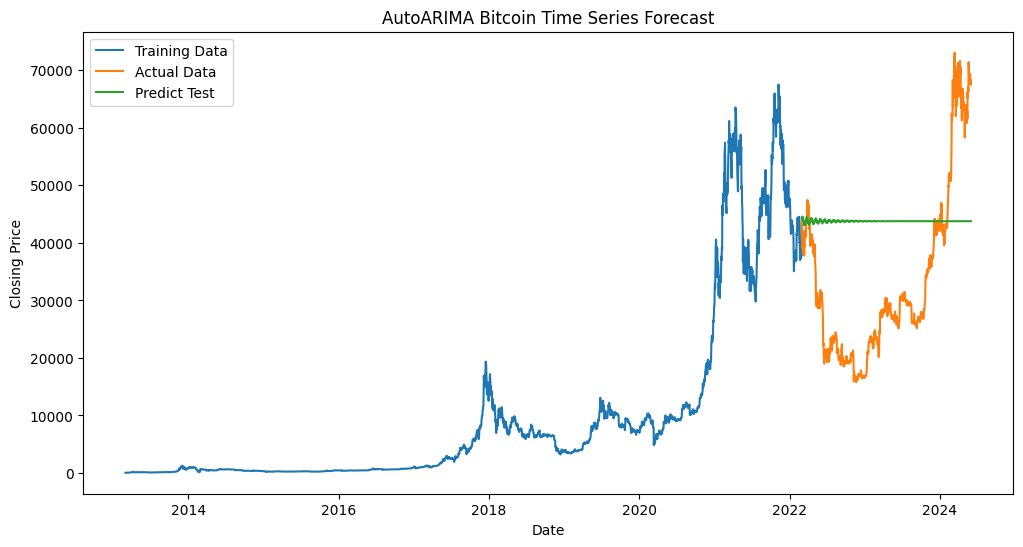

In [5]:
time_series = data['Price']

train_size = int(0.8 * len(time_series))
test_size = int(0.2 * len(time_series))

train_data = time_series[:train_size]

test_data = time_series[train_size:train_size+test_size]

model = auto_arima(train_data,
                   m=4, seasonal=True,
                     trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))

date_next_30_days = np.array(range(1, 31)).reshape(-1, 1)

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
plt.title('AutoARIMA Bitcoin Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## NASDAQ

In [6]:
data = pd.read_csv('NASDAQ Composite Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2013-03-01,3169.74,3143.54,3171.50,3129.40,431.39M,0.30%
2013-03-04,3182.03,3159.46,3182.27,3154.79,397.77M,0.39%
2013-03-05,3224.13,3200.38,3227.31,3200.27,418.69M,1.32%
2013-03-06,3222.37,3233.31,3233.44,3217.67,377.54M,-0.05%
2013-03-07,3232.09,3224.50,3235.10,3221.47,365.78M,0.30%
...,...,...,...,...,...,...
2024-05-24,16920.79,16786.79,16947.79,16771.58,953.61M,1.10%
2024-05-28,17019.88,16988.31,17032.65,16917.51,1.10B,0.59%
2024-05-29,16920.58,16879.35,16989.60,16873.97,1.15B,-0.58%


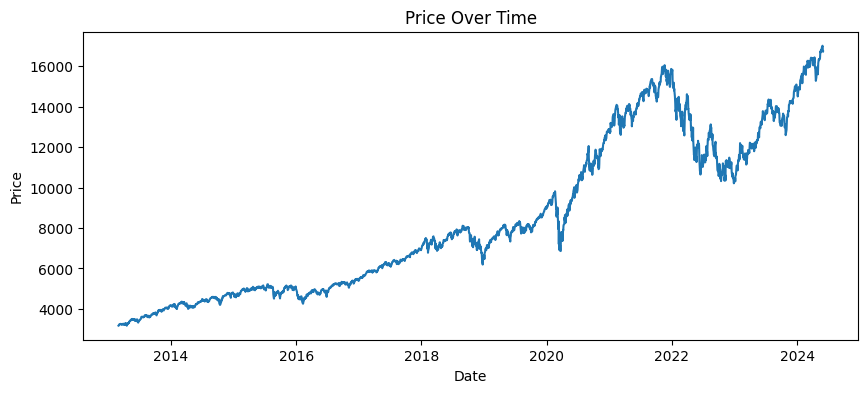

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(data['Price'])
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27481.511, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27519.105, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27486.167, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27490.232, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27521.576, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27480.961, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=27480.059, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=27479.499, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=27478.775, Time=1.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=27475.509, Time=1.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=27473.477, Time=2.70 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=27473.719, Time=2.28 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=27420.175, Time=2.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(5,1,3)(0,0,0)[0] i

d:\LearnPython\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\LearnPython\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


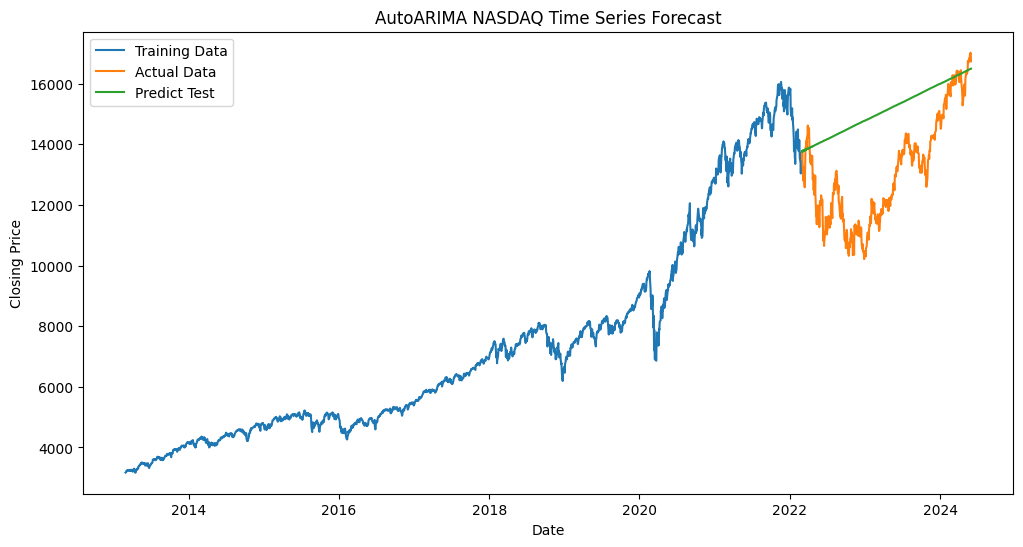

In [8]:
time_series = data['Price']

train_size = int(0.8 * len(time_series))
test_size = int(0.2 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size+test_size]

model = auto_arima(train_data,
                     trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))


# last_index = time_series.index[-1]
# last_index

# next_30_days = pd.date_range(start=time_series.index[train_size-1] + pd.DateOffset(days=1), periods=30, freq='D')

# future_index = pd.DataFrame(index=next_30_days)

date_next_30_days = np.array(range(1, 31)).reshape(-1, 1)
# price_next_30_days = model.predict(n_periods=len(date_next_30_days))

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
# plt.plot(future_index.index, price_next_30_days, label='Next 30 days')
plt.title('AutoARIMA NASDAQ Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## USD

In [9]:
data = pd.read_csv('US Dollar Index Futures Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2013-03-01,82.358,82.010,82.580,81.850,34.83K,0.43%
2013-03-04,82.255,82.355,82.530,82.230,19.76K,-0.13%
2013-03-05,82.147,82.210,82.300,81.955,25.02K,-0.13%
2013-03-06,82.507,82.020,82.640,81.975,26.04K,0.44%
2013-03-07,82.123,82.615,82.620,81.995,35.17K,-0.47%
...,...,...,...,...,...,...
2024-05-27,104.638,104.645,104.670,104.485,3.09K,0.00%
2024-05-28,104.539,104.490,104.560,104.260,11.02K,-0.09%
2024-05-29,105.034,104.590,105.085,104.515,17.66K,0.47%


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2237.359, Time=2.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2243.565, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2245.544, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2245.545, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2242.197, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2243.911, Time=0.75 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2244.214, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2239.883, Time=2.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2240.193, Time=2.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2246.417, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2239.080, Time=1.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2238.723, Time=2.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2241.918, Time=2.78 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2235.980, Time=1.12 sec
 ARIMA(1,1,2)(0,0,0)[0]          

d:\LearnPython\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\LearnPython\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


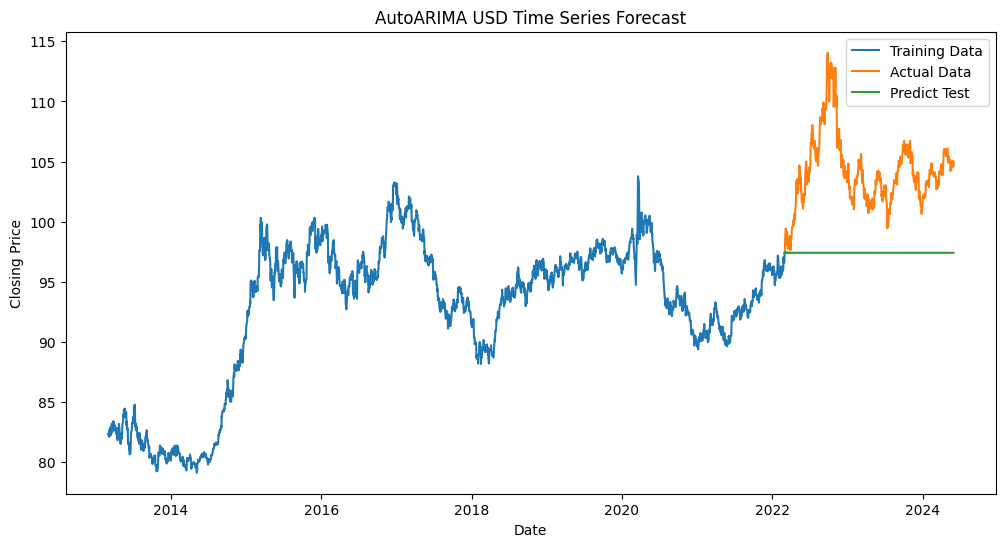

In [12]:
time_series = data['Price']

train_size = int(0.8 * len(time_series))
test_size = int(0.2 * len(time_series))

train_data = time_series[:train_size]
test_data = time_series[train_size:train_size+test_size]

model = auto_arima(train_data,
                     trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

model.fit(train_data)

pred_test = model.predict(n_periods=len(test_data))


# last_index = time_series.index[-1]
# last_index

# next_30_days = pd.date_range(start=time_series.index[train_size-1] + pd.DateOffset(days=1), periods=30, freq='D')

# future_index = pd.DataFrame(index=next_30_days)

date_next_30_days = np.array(range(1, 31)).reshape(-1, 1)
# price_next_30_days = model.predict(n_periods=len(date_next_30_days))

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, pred_test, label='Predict Test')
# plt.plot(future_index.index, price_next_30_days, label='Next 30 days')
plt.title('AutoARIMA USD Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()